In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,\
GradientBoostingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier,\
AdaBoostClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
%matplotlib inline

In [53]:
df=pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [136]:
df.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1


# EDA

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


 No Null Values

## Checking Categorical Columns

In [56]:
for col in df.dtypes[df.dtypes == object].index:
    print('Unique items in column',col,'are:',df[col].unique())
    print('-'*75)

No Categorical columns

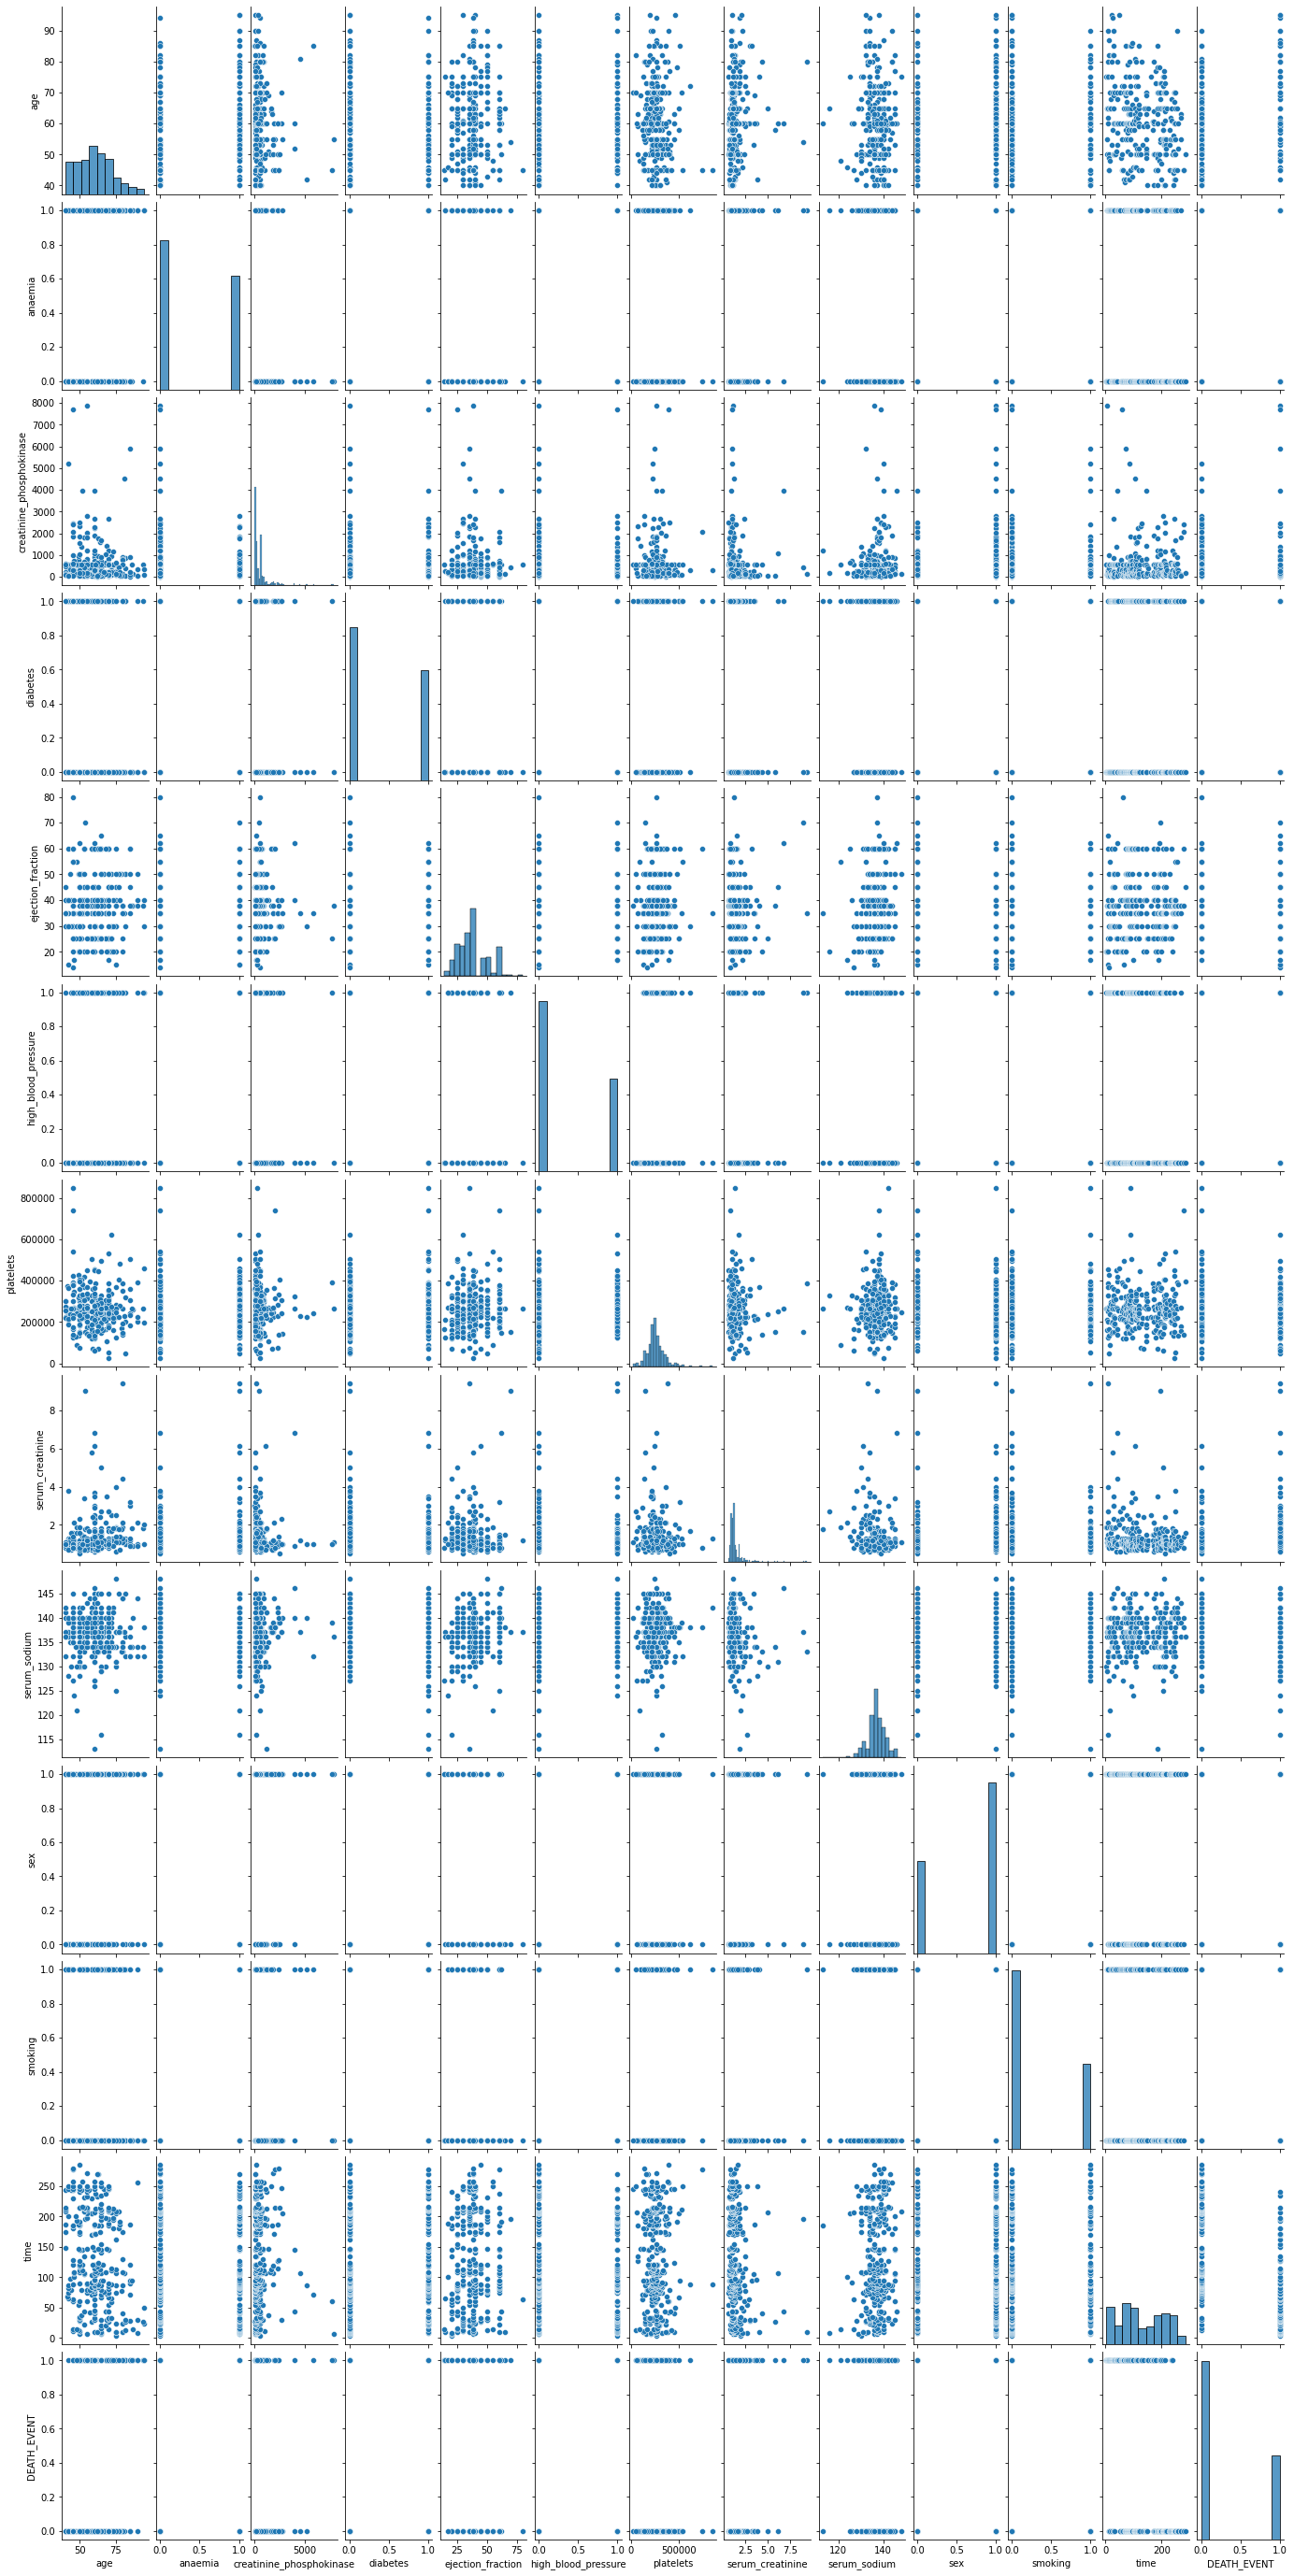

In [27]:
sns.pairplot(df,height=3, aspect=0.5)

 ## Correlation Analysis

In [19]:
df_corr = df.corr()
index = df_corr.index

<AxesSubplot:>

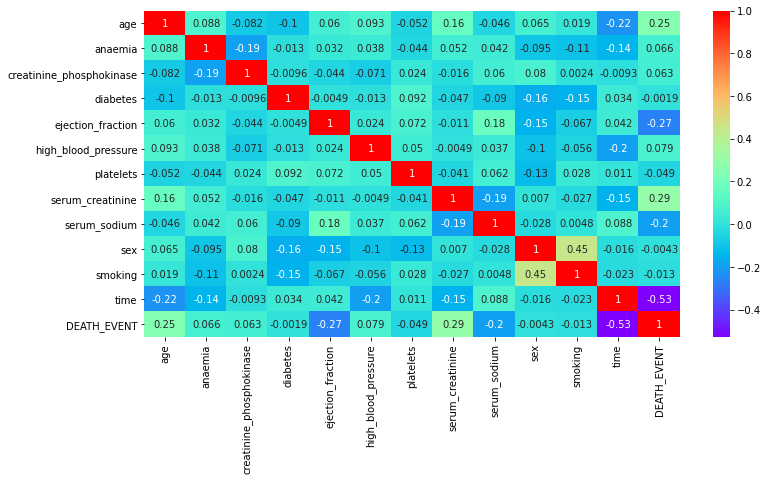

In [20]:
plt.figure(figsize = (12,6))
sns.heatmap(df[index].corr(),annot = True,cmap = 'rainbow')

 ## Checking Balance of Data

c:\users\aman\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

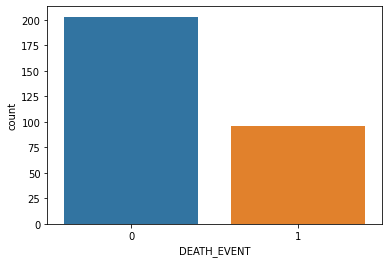

In [24]:
sns.countplot(df["DEATH_EVENT"])

In [25]:
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

Data is almost Balance

In [30]:
X = df.drop(['DEATH_EVENT'],axis = 1)
y = df['DEATH_EVENT']

In [31]:
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [35]:
threshold = .3

def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr

correlation(X,threshold)

{'smoking'}

# feature importance

In [57]:
model=ExtraTreesClassifier(random_state = 101)
model.fit(X,y)

ExtraTreesClassifier(random_state=101)

In [58]:
model.feature_importances_

array([0.09814937, 0.02583407, 0.080526  , 0.03017042, 0.13015785,
       0.02375219, 0.07293028, 0.1149952 , 0.08857714, 0.02412823,
       0.02703144, 0.28374778])

<AxesSubplot:>

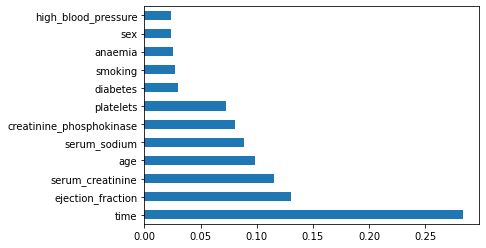

In [59]:
pd.Series(model.feature_importances_, index = X.columns).nlargest(len(X.columns)).plot(kind = 'barh')

## Modeling

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size=0.2)
XY_data = [X_train, X_test, Y_train, Y_test]

In [88]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [62]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [63]:
rf = RandomForestClassifier()

In [70]:
# Function to get optimal model using grid search CV (n_splits = 5, validation set = 0.175 of train set)
def GrCV(param,clf,XY_data):
    [X_train, X_test, Y_train, Y_test] = XY_data
    clf.fit(X_train,Y_train)
    Y_train_pred = clf.predict(X_train)
    Y_test_pred = clf.predict(X_test)
    print("Default Training F1 = {}".format(f1_score(Y_train_pred,\
                                                     Y_train,average='micro')))
    print("Default Test F1 = {}".format(f1_score(Y_test_pred,\
                                                 Y_test,average='micro')))
    cv_split = StratifiedKFold(n_splits = 3,shuffle = False)
    best_model = GridSearchCV(estimator = clf, param_grid = param, cv = cv_split,\
                              scoring = 'f1_micro',n_jobs=-1)
    best_model.fit(X_train, Y_train)
    best_param = best_model.best_params_
    print("Best parameters are : {}".format(best_param))
    clf.set_params(**best_param)
    clf.fit(X_train, Y_train)
    Y_train_pred = clf.predict(X_train)
    Y_test_pred = clf.predict(X_test)
    print("Training F1 = {}".format(f1_score(Y_train_pred,Y_train,average='micro')))
    print("Test F1 = {}".format(f1_score(Y_test_pred,Y_test,average='micro')))
    return clf

In [71]:
clf_rf_fitted=GrCV(random_grid,rf,XY_data)

Default Training F1 = 1.0
Default Test F1 = 0.8000000000000002
Best parameters are : {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 300}
Training F1 = 0.9043062200956937
Test F1 = 0.8777777777777779


In [113]:
# Function to train the given model on given data and print the accuracies
def train_predict(clf,XY_data):
    [X_train, X_test, Y_train, Y_test] = XY_data
    clf.fit(X_train,Y_train)
    Y_train_pred = clf.predict(X_train)
    Y_test_pred = clf.predict(X_test)
    print("Default Training Accuracy = {}".format(accuracy_score(Y_train_pred,Y_train)))
    print("Default Test Accuracy = {}".format(accuracy_score(Y_test_pred,Y_test)))
    print("Default Training F1 = {}".format(f1_score(Y_train_pred,Y_train,average='micro')))
    print("Default Test F1 = {}".format(f1_score(Y_test_pred,Y_test,average='micro')))

In [114]:
train_predict(clf,XY_data)

Default Training Accuracy = 0.9832635983263598
Default Test Accuracy = 0.8166666666666667
Default Training F1 = 0.9832635983263598
Default Test F1 = 0.8166666666666667


In [115]:
y_pred = clf_rf_fitted.predict(X_test)

In [116]:
y_pred

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0], dtype=int64)

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='Count'>

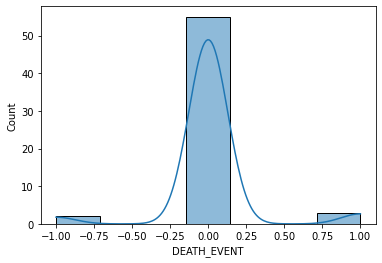

In [117]:
sns.histplot(Y_test - y_pred,kde = True)

In [118]:
print('Accuracy Score is:',accuracy_score(Y_test,y_pred))
print('F1 is:',f1_score(Y_test,y_pred,average='micro'))

Accuracy Score is: 0.9166666666666666
F1 is: 0.9166666666666666


In [120]:
import pickle
file = open('clf_rf.pkl','wb')
pickle.dump(clf_rf_fitted,file)

In [121]:
model = pickle.load(open('clf_rf.pkl', 'rb'))

In [123]:
pred=model.predict(X_test)

In [138]:
print('Accuracy Score is:',accuracy_score(Y_test,y_pred))
print('F1 is:',f1_score(Y_test,y_pred,average='micro'))

Accuracy Score is: 0.9166666666666666
F1 is: 0.9166666666666666
